##Muhammad Zaki
Kota Bukittinggi, Sumatera Barat
muhammadzaki476@gmail.com

import data

In [1]:
!wget --no-check-certificate \
  https://github.com//kaniang/nlp_reviewdisneyland/raw/main/disneyland_review.zip \
  -O /content/archive.zip

--2021-10-11 04:09:42--  https://github.com//kaniang/nlp_reviewdisneyland/raw/main/disneyland_review.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kaniang/nlp_reviewdisneyland/main/disneyland_review.zip [following]
--2021-10-11 04:09:42--  https://raw.githubusercontent.com/kaniang/nlp_reviewdisneyland/main/disneyland_review.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11639652 (11M) [application/zip]
Saving to: ‘/content/archive.zip’

/content/archive.zi 100%[===================>]  11.10M  58.6MB/s    in 0.2s    

2021-10-11 04:09:44 (58.6 MB/s) - ‘/content/archive.zip’ saved [11639

In [2]:
import zipfile,os
local_zip = '/content/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

data preprocessing

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('DisneylandReviews.csv',encoding = "ISO-8859-1", engine='python')
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


data cleansing

In [5]:
df = df.drop(columns=['Review_ID','Year_Month','Reviewer_Location','Branch'])
df.dropna(inplace=True)
df.head()

,Rating,Review_Text
0,4,If you've ever been to Disneyland anywhere you...
1,4,Its been a while since d last time we visit HK...
2,4,Thanks God it wasn t too hot or too humid wh...
3,4,HK Disneyland is a great compact park. Unfortu...
4,4,"the location is not in the city, took around 1..."


In [6]:
print('DataFrame:\n', df)

DataFrame:
        Rating                                        Review_Text
0           4  If you've ever been to Disneyland anywhere you...
1           4  Its been a while since d last time we visit HK...
2           4  Thanks God it wasn   t too hot or too humid wh...
3           4  HK Disneyland is a great compact park. Unfortu...
4           4  the location is not in the city, took around 1...
...       ...                                                ...
42651       5  i went to disneyland paris in july 03 and thou...
42652       5  2 adults and 1 child of 11 visited Disneyland ...
42653       5  My eleven year old daughter and myself went to...
42654       4  This hotel, part of the Disneyland Paris compl...
42655       4  I went to the Disneyparis resort, in 1996, wit...

[42656 rows x 2 columns]


learning data

In [7]:
#one hot encoding
category = pd.get_dummies(df.Rating)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Rating')
df_baru.head()

,Review_Text,1,2,3,4,5
0,If you've ever been to Disneyland anywhere you...,0,0,0,1,0
1,Its been a while since d last time we visit HK...,0,0,0,1,0
2,Thanks God it wasn t too hot or too humid wh...,0,0,0,1,0
3,HK Disneyland is a great compact park. Unfortu...,0,0,0,1,0
4,"the location is not in the city, took around 1...",0,0,0,1,0


In [8]:
review = df_baru['Review_Text'].values
label = df_baru[[1,2,3,4,5]].values

In [9]:
from sklearn.model_selection import train_test_split
sinopsis_latih, sinopsis_test, label_latih, label_test = train_test_split(review, label, test_size=0.2)

In [10]:
#tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=10000, oov_token='x',filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n(1234567890)',lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(sinopsis_latih)
tokenizer.fit_on_texts(sinopsis_test)
 
sekuens_latih = tokenizer.texts_to_sequences(sinopsis_latih)
sekuens_test = tokenizer.texts_to_sequences(sinopsis_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import regularizers
from tensorflow.keras import layers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [12]:
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print('target akurasi terpenuhi')
      self.model.stop_training = True
cb = callback()

In [13]:
num_epochs = 40
history = model.fit(padded_latih, label_latih, batch_size=1024, epochs=num_epochs,validation_data=(padded_latih, label_latih), verbose=2, callbacks= cb)

Epoch 1/40
34/34 - 53s - loss: 1.5604 - accuracy: 0.5307 - val_loss: 1.1429 - val_accuracy: 0.5440
Epoch 2/40
34/34 - 46s - loss: 1.0879 - accuracy: 0.5444 - val_loss: 1.0358 - val_accuracy: 0.5440
Epoch 3/40
34/34 - 46s - loss: 0.9906 - accuracy: 0.5749 - val_loss: 0.9255 - val_accuracy: 0.5979
Epoch 4/40
34/34 - 46s - loss: 0.9143 - accuracy: 0.6087 - val_loss: 0.8834 - val_accuracy: 0.6258
Epoch 5/40
34/34 - 46s - loss: 0.8730 - accuracy: 0.6347 - val_loss: 0.8186 - val_accuracy: 0.6639
Epoch 6/40
34/34 - 46s - loss: 0.8257 - accuracy: 0.6556 - val_loss: 0.7691 - val_accuracy: 0.6711
Epoch 7/40
34/34 - 46s - loss: 0.7825 - accuracy: 0.6741 - val_loss: 0.7285 - val_accuracy: 0.7033
Epoch 8/40
34/34 - 46s - loss: 0.7707 - accuracy: 0.6834 - val_loss: 0.7586 - val_accuracy: 0.6777
Epoch 9/40
34/34 - 46s - loss: 0.7380 - accuracy: 0.6987 - val_loss: 0.6612 - val_accuracy: 0.7394
Epoch 10/40
34/34 - 46s - loss: 0.7101 - accuracy: 0.7194 - val_loss: 0.6358 - val_accuracy: 0.7576
Epoch 11/

In [14]:
from matplotlib import pyplot as plt

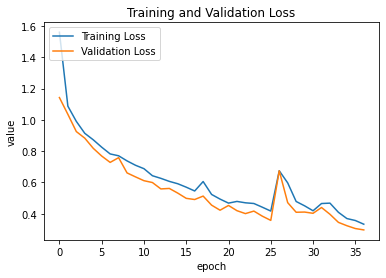

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

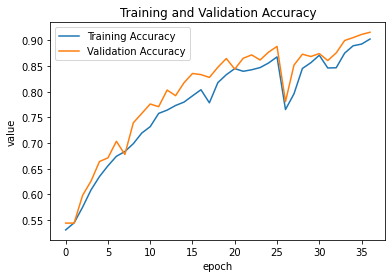

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()